In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import numpy, os, pandas 

In [3]:
import tensorflow

In [4]:
from tensorflow import keras

In [5]:
print(tensorflow.__version__)

1.11.0


In [6]:
AmesHousing = pandas.read_excel('../data/AmesHousing.xls')
AmesHousing.head(10)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
5,6,527105030,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,195500
6,7,527127150,120,RL,41.0,4920,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,213500
7,8,527145080,120,RL,43.0,5005,Pave,NaN,IR1,HLS,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191500
8,9,527146030,120,RL,39.0,5389,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,236500
9,10,527162130,60,RL,60.0,7500,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,189000


In [7]:
cd ..

D:\UofMemphis\Fall-18\COMP6993\DSP-COMP6993


In [8]:
from libpy import NS_dp

In [9]:
from sklearn.model_selection import train_test_split

We use our own function to clean Data

In [10]:
df = NS_dp.clean_Ames_Housing(AmesHousing)

E:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [11]:
data, labels = df.iloc[ : , 2: ].drop( columns=[ "SalePrice" ] ), df[ "SalePrice" ]

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

In [13]:
from libpy import FS

In [14]:
# train_data, train_labels, test_data, test_labels = FS.feature_select(df)

In [15]:
print("Training set: {}".format(train_data.shape))  # 1607 examples, ** features
print("Testing set:  {}".format(test_data.shape))   # 1071 examples, 13 features

Training set: (2142, 210)
Testing set:  (536, 210)


In [16]:
train_data.sample(10)

,Overall Cond,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,...,BsmtFin Type 2,Electrical,Functional,Kitchen Qual,Heating QC,Bsmt Cond,Garage Finish,Garage Qual,Garage Cond,Paved Drive
1117,6,1965,1965,1.0,0.0,1,0,3,1,5,...,5.0,4.0,7.0,4.0,4.0,4.0,1.0,4.0,4.0,2.0
286,5,2003,2003,0.0,0.0,2,0,3,1,7,...,5.0,4.0,7.0,2.0,0.0,4.0,0.0,4.0,4.0,2.0
2401,6,1959,1959,0.0,1.0,1,0,3,1,6,...,5.0,4.0,7.0,4.0,0.0,4.0,0.0,4.0,4.0,2.0
854,6,1980,1992,1.0,0.0,1,1,2,1,5,...,5.0,4.0,7.0,2.0,4.0,4.0,0.0,4.0,4.0,2.0
383,5,1977,1977,0.0,0.0,2,1,3,1,6,...,5.0,4.0,7.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0
377,7,1972,1972,0.0,0.0,2,1,3,1,6,...,5.0,4.0,7.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0
1196,5,1948,1950,0.0,0.0,1,0,2,1,5,...,1.0,4.0,7.0,4.0,0.0,4.0,2.0,4.0,4.0,2.0
1981,5,2007,2007,0.0,0.0,2,1,3,1,7,...,5.0,4.0,7.0,2.0,0.0,4.0,1.0,4.0,4.0,2.0
2061,6,1974,1974,1.0,0.0,1,0,2,1,5,...,5.0,4.0,7.0,4.0,4.0,4.0,2.0,4.0,4.0,2.0
910,5,1998,1998,1.0,0.0,2,1,3,1,7,...,5.0,4.0,7.0,4.0,2.0,4.0,0.0,4.0,4.0,2.0


### Model building

Here we created a neural network of our own. Trained it and ecaluted it's score to to measure performance. Later we plot our results.

### Train a model

In [17]:
from libpy import KR

Here we use default 64 node Neural Network

In [18]:
model = KR.build_model(train_data)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                13504     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 21,889
Trainable params: 21,889
Non-trainable params: 0
_________________________________________________________________


In [19]:
history, model = KR.train_model( model, train_data, train_labels )


....................................................................................................
....................................................................................................
..........................

In below, we calculate the mae score to find test accuracy, aka our model's accuracy

In [23]:
[loss, mae] = model.evaluate(test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format( mae ))

Testing set Mean Abs Error: $18051.26


In [24]:
test_predictions = model.predict(test_data).flatten()

### Plot

Here we plot our model performance. 

In [20]:
from matplotlib import pyplot

In [21]:
from libpy import DNN_plot

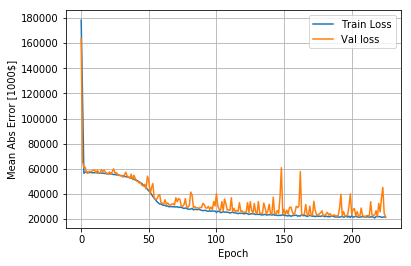

In [22]:
DNN_plot.plot_history(history)

We shown our Training vs Validation loss. Here we used tf.losses.mean_squared_error (mse) as loss aprameter and mean_absolute_error (mae) to plot our Training performaance

Here we can see the Regression model 

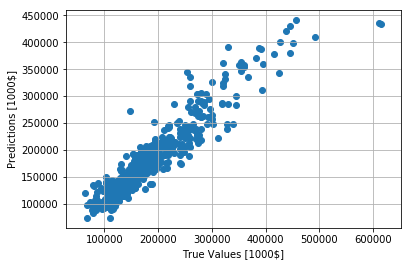

In [25]:
DNN_plot.plot_predict( test_labels, test_predictions )

In the above graph, we can relate Test Labels vs Predicted Labels. Thus gives us the idea, how much price difference our model gives. As we can see, the result is related, can predict better at low price, but gives error for higher priced houses.

As, we have predicting price, we can now check how much price difference we are getting.

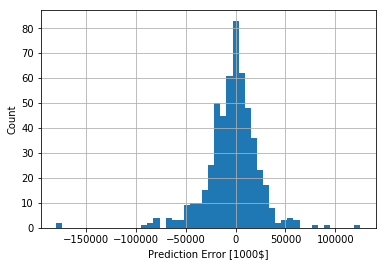

In [26]:
DNN_plot.plot_predict_error(test_labels, test_predictions)

### Experiment Depth of Neural Network

We want to check with increase of Hidden layer, does our model performs better? We increased up to 8 hidden layer

In [27]:
from libpy import CV


.
.......................................................................................................................................................................................................
.
.......................................................................................................................................................................................................
.
.......................................................................................................................................................................................................
.
.......................................................................................................................................................................................................
.
.............................................................................................................................................................................................

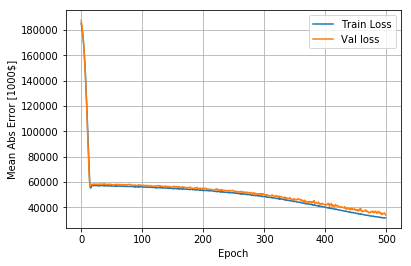

Testing set Mean Abs Error: $29031.62


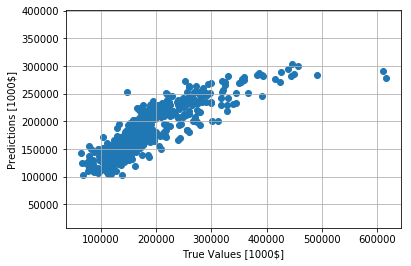


.
.
..........................................................................................................................................................................................................................................................................................................
.
.
..........................................................................................................................................................................................................................................................................................................
.
.
..........................................................................................................................................................................................................................................................................................................
.
.
......................................................................................

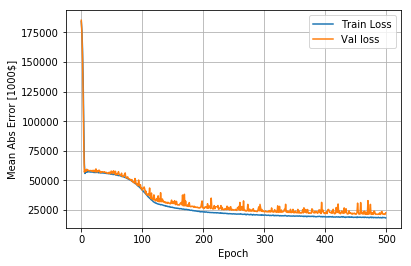

Testing set Mean Abs Error: $19288.01


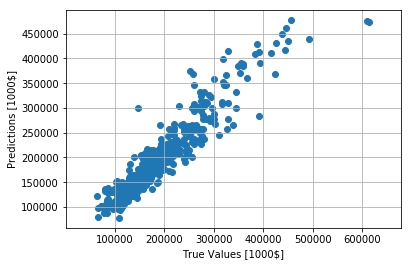


.
.
.
.............................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.............................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.........................................................................................................................................................................................

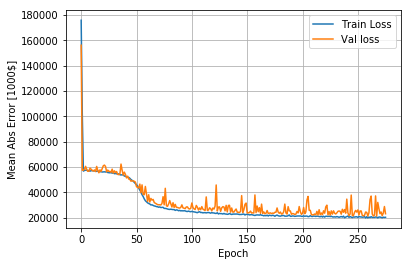

Testing set Mean Abs Error: $19173.34


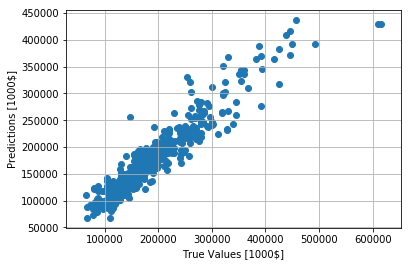


.
.
.
.
................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

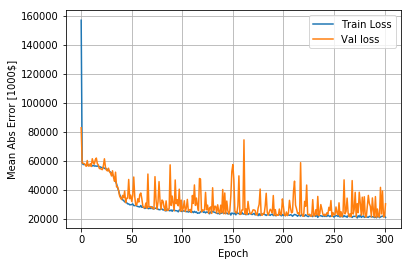

Testing set Mean Abs Error: $27812.06


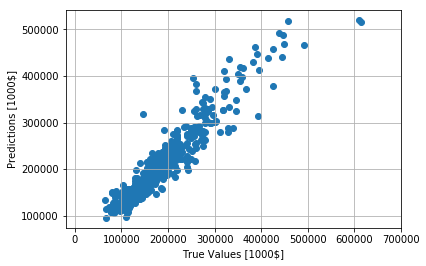


.
.
.
.
.
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.
.
................................................................................................................................................................................................._________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                135

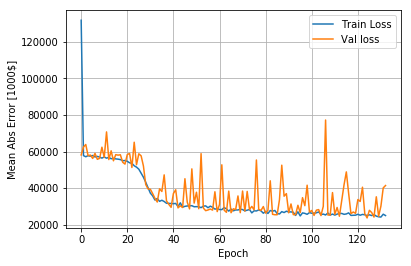

Testing set Mean Abs Error: $38311.26


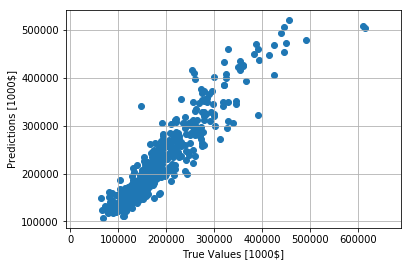


.
.
.
.
.
.
......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.
.
.
........................................................................................................................................................................................................................................................................................

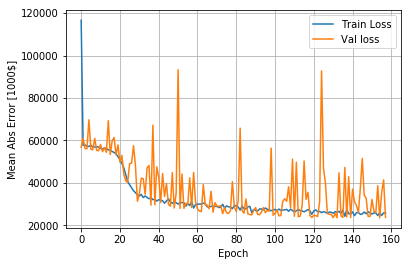

Testing set Mean Abs Error: $19541.78


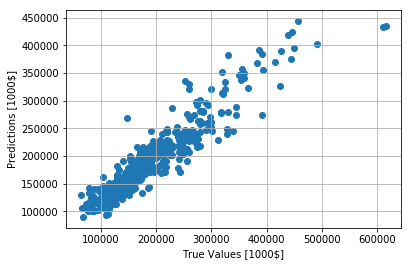


.
.
.
.
.
.
.
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.
.
.
.
.................................................................................................................................................................................

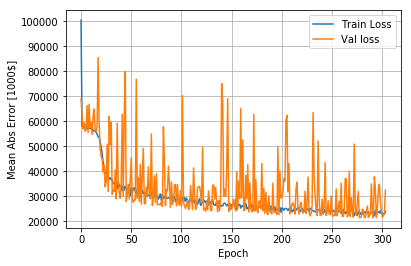

Testing set Mean Abs Error: $28219.88


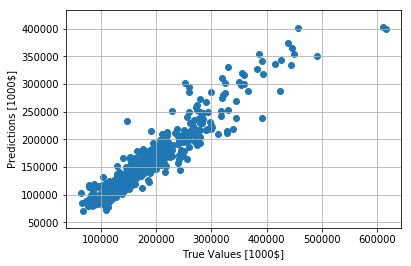

In [28]:
depths = []
scores_mae = []

for i in range( 7 ):
    model = KR.build_model(train_data, depth=i)    
    
    history, model = KR.train_model( model, train_data, train_labels )
    print("")
    model.summary()
    
    DNN_plot.plot_history(history)
    
    [loss, mae] = model.evaluate(test_data, test_labels, verbose=0)
    print("Testing set Mean Abs Error: ${:7.2f}".format( mae ))
    
    test_predictions = model.predict(test_data).flatten()
    DNN_plot.plot_predict( test_labels, test_predictions )
    
    depths.append( i+2 )
    scores_mae.append( mae)    

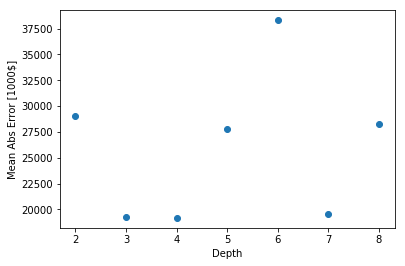

In [29]:
CV.plot_any( depths, scores_mae, xlabel='Depth', ylabel='Mean Abs Error [1000$]' )

We find out based on our experiment, Depth has effect felt random to us and with increase of depth, any visible improvement in accuracy was not made. But, based on the result, we kept default depth to 4.  

### Experiment Overfitting

In this part, we try multiple neural network model, with various node number to check Overfitting vs Underfitting 

In [30]:
model_16 = KR.build_model(train_data, units=16)
history_16, model_16 = KR.train_model( model_16, train_data, train_labels )
model_16.summary()


.
.
.
.
.
.
.
.
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
.
.
.
.
.
.
.
.
..........................................................................

In [31]:
loss, acc = model_16.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc ))

2142/2142 [==============================] - 0s 53us/step
Trained model, accuracy: 18471.21%


In [32]:
model_32 = KR.build_model(train_data, units=32)
history_32, model_32 = KR.train_model( model_32, train_data, train_labels )
model_32.summary()


.
.
.
.
.
.
.
.
.
.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [33]:
loss, acc = model_32.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc))

2142/2142 [==============================] - 0s 51us/step
Trained model, accuracy: 31917.29%


In [34]:
model_48 = KR.build_model(train_data, units=48)
history_48, model_48 = KR.train_model( model_48, train_data, train_labels )
model_48.summary()


.
.
.
.
.
.
.
.
.
.
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [35]:
loss, acc = model_48.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc))

2142/2142 [==============================] - 0s 60us/step
Trained model, accuracy: 18281.55%


In [36]:
model_64 = KR.build_model( train_data, units=64 )
history_64, model_64 = KR.train_model( model_64, train_data, train_labels )
model_64.summary()


.
.
.
.
.
.
.
.
.
.
.
.................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [37]:
loss, acc = model_64.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc))

2142/2142 [==============================] - 0s 56us/step
Trained model, accuracy: 38304.85%


In [38]:
model_128 = KR.build_model( train_data, units=128)
history_128, model_128 = KR.train_model( model_128, train_data, train_labels )
model_128.summary()


.
.
.
.
.
.
.
.
.
.
.
.
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [39]:
loss, acc = model_128.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc))

2142/2142 [==============================] - 0s 57us/step
Trained model, accuracy: 29156.59%


In [40]:
model_512 = KR.build_model(train_data, units=512)
history_512, model_512 = KR.train_model( model_512, train_data, train_labels )
model_512.summary()


.
.
.
.
.
.
.
.
.
.
.
.
.
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [41]:
loss, acc = model_512.evaluate( train_data, train_labels )
print("Trained model, accuracy: {:5.2f}%".format( acc))

2142/2142 [==============================] - 0s 63us/step
Trained model, accuracy: 23475.53%


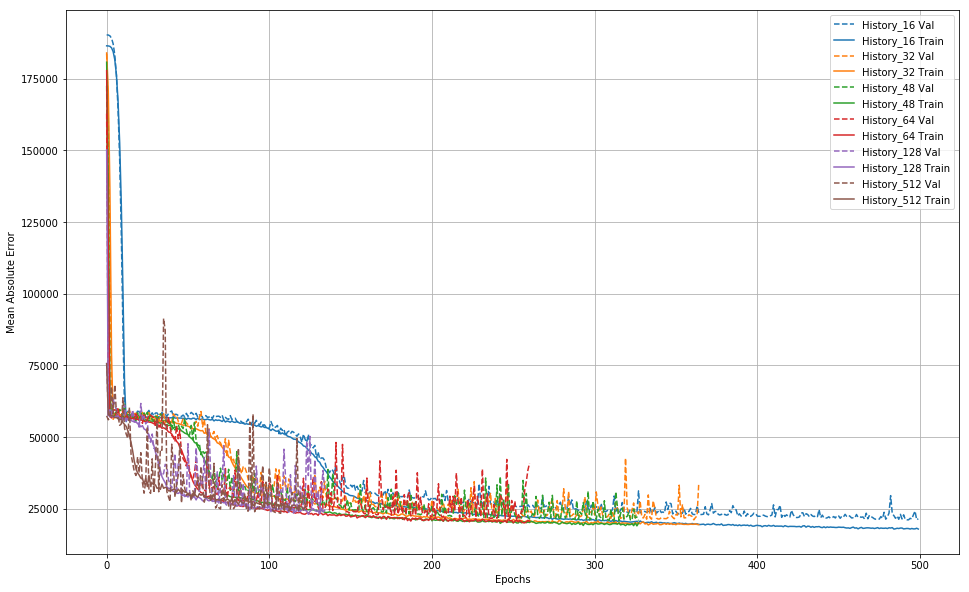

In [42]:
DNN_plot.plot_compare_history( [
    ('history_16', history_16 ),
    ('history_32', history_32 ),
    ('history_48', history_48 ),
    ('history_64', history_64 ),
    ('history_128', history_128 ),
    ('history_512', history_512 )
] )

In our case, Validation and Training loss corrosponds to each other, all the models does not face any Overfitting or Underfitting. As we used EarlyStopping to stop training when val_loss stops to update. At the same time we used keras.regularizers.l2 to regularize our model.

We found accuracy difference in Models with different number of Units. 